<a href="https://colab.research.google.com/github/ColeHenson/Data-Science24-25/blob/main/ColeHensU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

## Data

The data I decided to use for this project are the salaries offered for positions in data science collected from 2020-2024. The data is from listings rather than actual accepted jobs so I would expect to see lower values than an employee that has worked as a data scientist for a longer time. That is a lot of data so depending on how long my model takes to run I may trim it down to just data from 2024. Since this class is a data science class and we are here to learn skills that will be useful for real world applications, I think it would be interesting to look at the pay for data scientists. The data comes from all over the world so there is likely to be variation in the results from what I would expect for a lasa student with a career in data science in their future. There is also some question as to whether this data should be treated as continuous of discrete. I chose to treat it as continuous because theoretically these jobs could be listed for any real number and some of them actually are because the listed salaries are adjusted by an exchange rate in the real numbers. That said most salary listings end up being "nice" numbers.

In [5]:
#load the data from my github page.
#dss is data science salary
url_cs = 'https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/refs/heads/main/DataScience_salaries_2024.csv'
#I could have put the url string directly into pd.read_csv()
dss_data = pd.read_csv(url_cs)
dss_data


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L
...,...,...,...,...,...,...,...,...,...,...,...
14833,2022,MI,FT,Business Intelligence Developer,15000,USD,15000,GH,100,GH,M
14834,2020,EX,FT,Staff Data Analyst,15000,USD,15000,NG,0,CA,M
14835,2021,EN,FT,Machine Learning Developer,15000,USD,15000,TH,100,TH,L
14836,2022,EN,FT,Data Analyst,15000,USD,15000,ID,0,ID,L


In [6]:
#I only care about the position level and income in usd
df = pd.DataFrame(dss_data)
dss_df = df[["experience_level","salary_in_usd"]]

<Axes: >

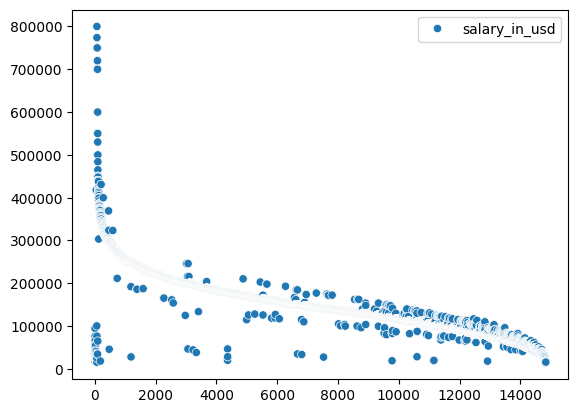

In [7]:
# I decided to make a scatter plot to see how the data is organized
sns.scatterplot(dss_df)

This is an interesting looking scatter plot. Looking closer at the data, I think the reason it looks like this is because the data is sorted by salary in whatever currency is relevant to each employee and I am plotting usd so there is some variation based on the currencies used in the data. The grey line in the middle is actually a bunch of different data points bunched up together likely from people being payed in usd and ordered by quantity.

(array([5.860e+02, 1.952e+03, 2.885e+03, 3.446e+03, 2.659e+03, 1.622e+03,
        9.270e+02, 4.170e+02, 1.850e+02, 6.700e+01, 3.200e+01, 2.600e+01,
        5.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+01, 8.000e+00, 2.000e+00]),
 array([ 15000.        ,  50681.81818182,  86363.63636364, 122045.45454545,
        157727.27272727, 193409.09090909, 229090.90909091, 264772.72727273,
        300454.54545455, 336136.36363636, 371818.18181818, 407500.        ,
        443181.81818182, 478863.63636364, 514545.45454545, 550227.27272727,
        585909.09090909, 621590.90909091, 657272.72727273, 692954.54545455,
        728636.36363636, 764318.18181818, 800000.        ]),
 <BarContainer object of 22 artists>)

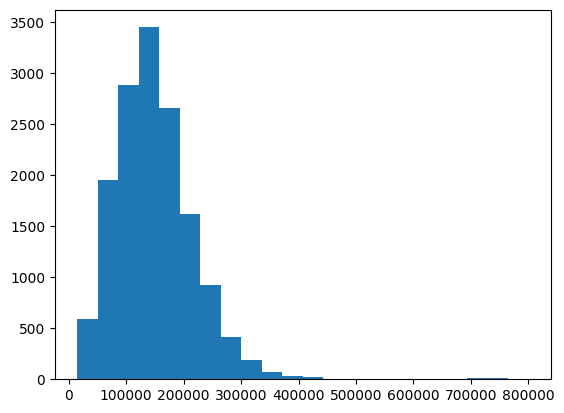

In [8]:
# histogram plot to get a look at what the data looks like
plt.hist(dss_df['salary_in_usd'], bins = 22)

This histogram is pretty nice. It has a clear mode and a clear right skew which we would expect because the pay for data scientist must be greater than 0 and there are some number of them that make a lot more money than others. These we would expect to be higher level employees. I want a model with a right skew and I will use a skew student T because that is what I am familiar with and a gamma distribution because it returns strictly positive values which I want.

Now it is time to start modeling!!!!!!!!


In [9]:
# first I will encode the different categories of data science position
# dsp means data science position
dsp_encode = pd.Categorical(dss_df['experience_level'])
# these are junior mid-level senior and expert
# junior(entry) = en, mid-level = MI, senior = SE, and expert = ex
dsp_encode


['MI', 'MI', 'MI', 'MI', 'SE', ..., 'MI', 'EX', 'EN', 'EN', 'EN']
Length: 14838
Categories (4, object): ['EN', 'EX', 'MI', 'SE']

In [10]:
dsp_coords = {"experience_level": dsp_encode.categories}
experience_level_idx = dsp_encode.codes
dsp_coords

{'experience_level': Index(['EN', 'EX', 'MI', 'SE'], dtype='object')}

# Skewed Student T Distribution

In [ ]:
# non hierarchical model
with pm.Model(coords=dsp_coords) as dss_nh_model:
    μ = pm.Normal('μ',
                  mu = 150000,
                  sigma = 100000,
                  dims = "experience_level")
    σ = pm.HalfNormal('σ', sigma = 100000,
                      dims = "experience_level")
    # I want some amount of right skew so I am going to make a bigger than b
    # this is an arbitrary choice based on the fact that I know there will be
    # some number of salary listings on the higher end of of the data set and
    # the salaries must be some value > 0.
    # half normal because I want some level of uncertainty
    a = pm.HalfNormal('a', sigma=5)
    b = pm.HalfNormal('b', sigma=2)
    # I am using a skew student T because the data is skewed and looks like
    # it roughly matches a student t distribution.
    y = pm.SkewStudentT('y',
                  mu = μ[experience_level_idx],
                  sigma = σ[experience_level_idx],
                  a = a,
                  b = b,
                  observed = dss_df['salary_in_usd'])

    #dss for data science salary nh for nonhierarchical
    idata_dss_nh = pm.sample()

In [ ]:
with pm.Model(coords=dsp_coords) as dss_h_model:
    # for my hyperpriors I am setting the mean to 150,000 because that seems
    # about right for the data and standard deviation to 100,000 again based on
    # eyeballing my histogram.
    μ_mu = pm.Normal('μ_mu', mu = 150000, sigma = 100000)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 100000)
    #
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "experience_level")

    σ = pm.HalfNormal('σ', sigma = 100000,
                      dims = "experience_level")
    # I want some amount of right skew so I am going to make a bigger than b
    # this is an arbitrary choice based on the fact that I know there will be
    # some number of salary listings on the higher end of of the data set and
    # the salaries must be some value > 0.
    # half normal because I want some level of uncertainty
    a = pm.HalfNormal('a', sigma=5)
    b = pm.HalfNormal('b', sigma=2)
    # I am using a skew student T because the data is skewed and looks like
    # it roughly matches a student t distribution.
    y = pm.SkewStudentT('y',
                  mu = μ[experience_level_idx],
                  sigma = σ[experience_level_idx],
                  a = a,
                  b = b,
                  observed = dss_df['salary_in_usd'])

    #dss for data science salary h for hierarchical
    idata_dss_h = pm.sample()

Output()

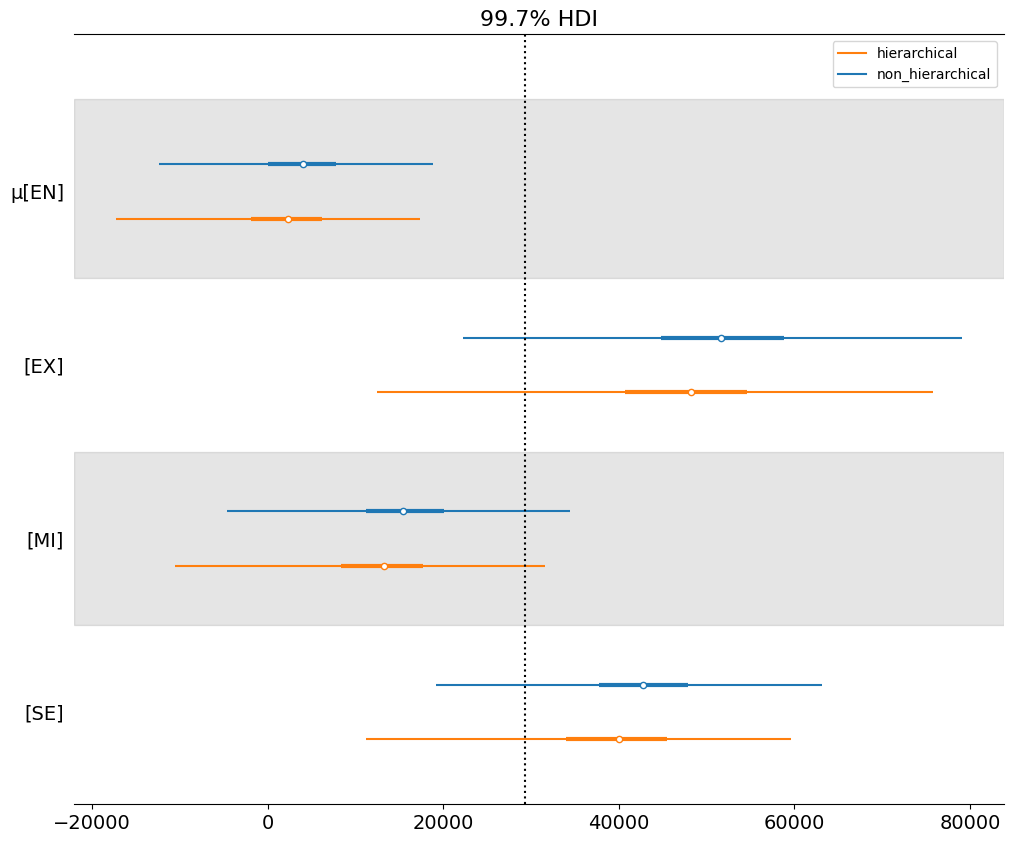

In [23]:
# copied code from the notes
# compare the h and nh models
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_dss_nh, idata_dss_h], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_dss_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");


It seems like the non hierarchical model trends toward higher values for mu. I noticed some of the mu values are negative which I don't want.

Output()

<Axes: xlabel='y'>

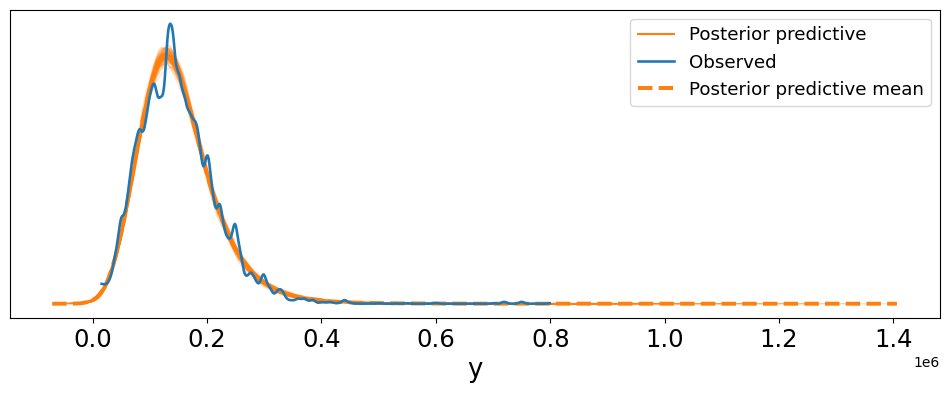

In [9]:
# plot nonhierarchical model ppc
pm.sample_posterior_predictive(idata_dss_nh, model=dss_nh_model, extend_inferencedata=True)
az.plot_ppc(idata_dss_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

<Axes: xlabel='y'>

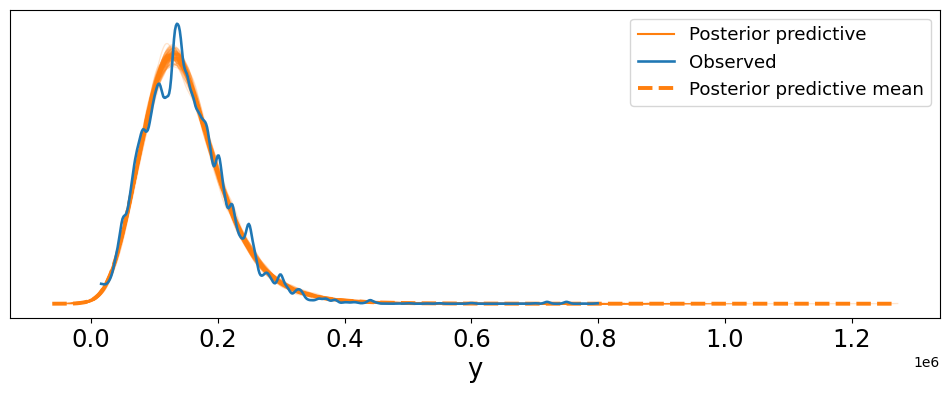

In [18]:
# plot hierarchical model ppc
pm.sample_posterior_predictive(idata_dss_h, model=dss_h_model, extend_inferencedata=True)
az.plot_ppc(idata_dss_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])


The model is acutally really close to the data. One thing I am noticing is that there are all these spikes in the data. I suspect this is because humans like nice clean numbers so the job listings are more likely to have values like 100,000 rather than 121,650. This pattern likely only exists in the usd numbers because exchange rates are usually not "nice" numbers

Comparing the bottom hierarchical model with the top non hierarchical model there isn't really a tangible difference. All in all this model probably didn't need to be hierarchical because the nh works so well. That might mean there isn't that much dependence between the different positon types.

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

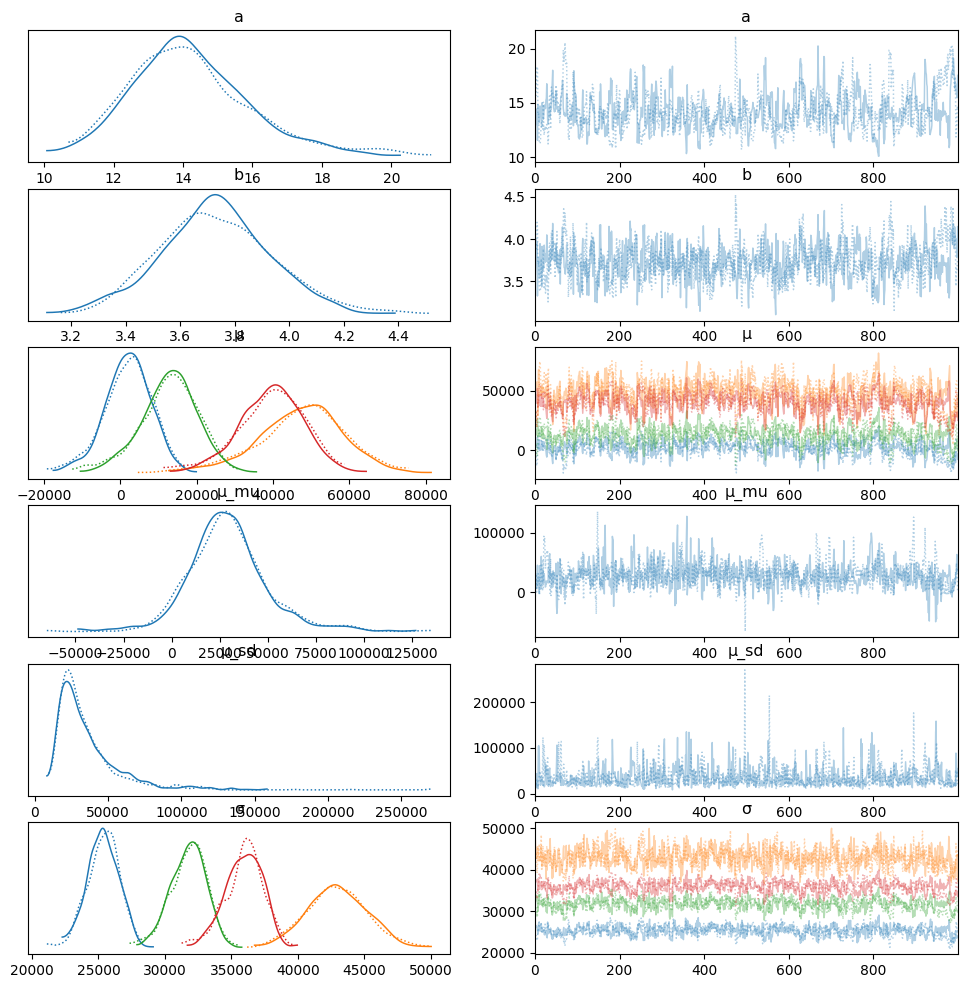

In [19]:
az.plot_trace(idata_dss_h)

In [10]:
az.rhat(idata_dss_h)
az.rhat(idata_dss_nh)

NameError: name 'idata_dss_h' is not defined

All the rhat values are pretty reasonable around 1.005. They could be better though. As for the category results, it seems that the pay matches the level of experience pretty closely and even the standard deviations between the categories are pretty much the same. That is except the expert level job listings. I think this is because there are just less data points for expert level job listings.

# Conclusion

Overall the hierarchical and nonhierarchical models performed basically the same. The low rhat values tell me that the models generally did a good job and a skew T is a good fit becuase the data has skew. The shape of the model also folled the data pretty smoothly aside from those spikes resulting from the human desire to see the number 0. In consideration of the context of the model I think a lot of the results are expected, more experienced roles pay better. What was somewhat unexpected for me is how consistently the higher levels of listed experience pay better. I would have expected other variables such as country to impact the pay as well and they probably do, just not as much as I expected.

## Gamma Distribution
I tried this, I'm  not really sure what went wrong but I am going to focus on the student's t because it worked and my gamma model did not. I think the problem might be related to negative values


Now I am going to try a gamma distribution as my likelyhood. Gamma distributions are strictly positive which I want since my data is strictly positive.

In [30]:
# same as before with G for gamma
with pm.Model(coords=dsp_coords) as dss_h_model_g:
    # same hyperpriors since I am using a mu sigma gamma and hyperpriors are for
    # mu
    μ_mu = pm.Normal('μ_mu', mu = 150000, sigma = 100000)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 100000)
    #
    μ = pm.TruncatedNormal('μ',lower = 0,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "experience_level")

    σ = pm.HalfNormal('σ', sigma = 100000,
                      dims = "experience_level")
    # I am using a gamma because the shape of the data looks like a gamma
    y = pm.Gamma('y',
                  mu = μ[experience_level_idx],
                  sigma = σ[experience_level_idx],
                  observed = dss_df['salary_in_usd'])

    #dss for data science salary h for hierarchical
    idata_dss_h_g = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5453: RuntimeWarning: divide by zero 
encountered in divide
  return d2 / d3

<Axes: xlabel='y'>

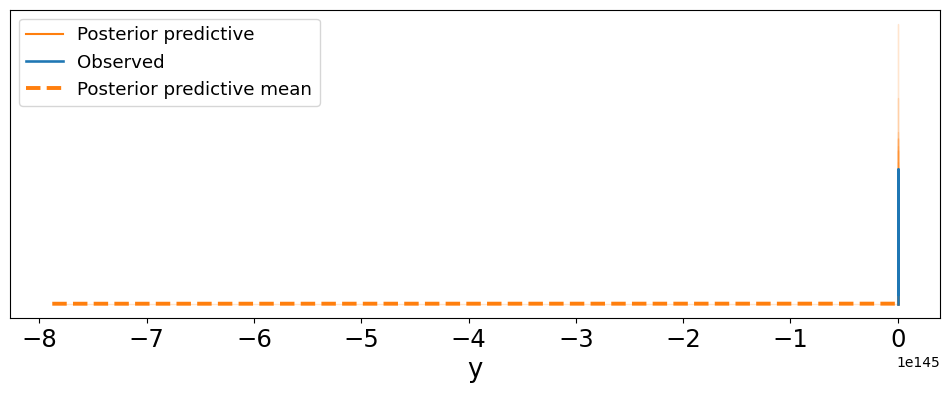

In [31]:
pm.sample_posterior_predictive(idata_dss_h_g, model=dss_h_model, extend_inferencedata=True)
az.plot_ppc(idata_dss_h_g, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

<xarray.Dataset> Size: 112B
Dimensions:           (experience_level: 4)
Coordinates:
  * experience_level  (experience_level) <U2 32B 'EN' 'EX' 'MI' 'SE'
Data variables:
    μ                 (experience_level) float64 32B 1.001 1.002 1.0 1.001
    μ_mu              float64 8B 1.0
    μ_sd              float64 8B 0.9996
    σ                 (experience_level) float64 32B 1.006 1.001 1.001 0.9994

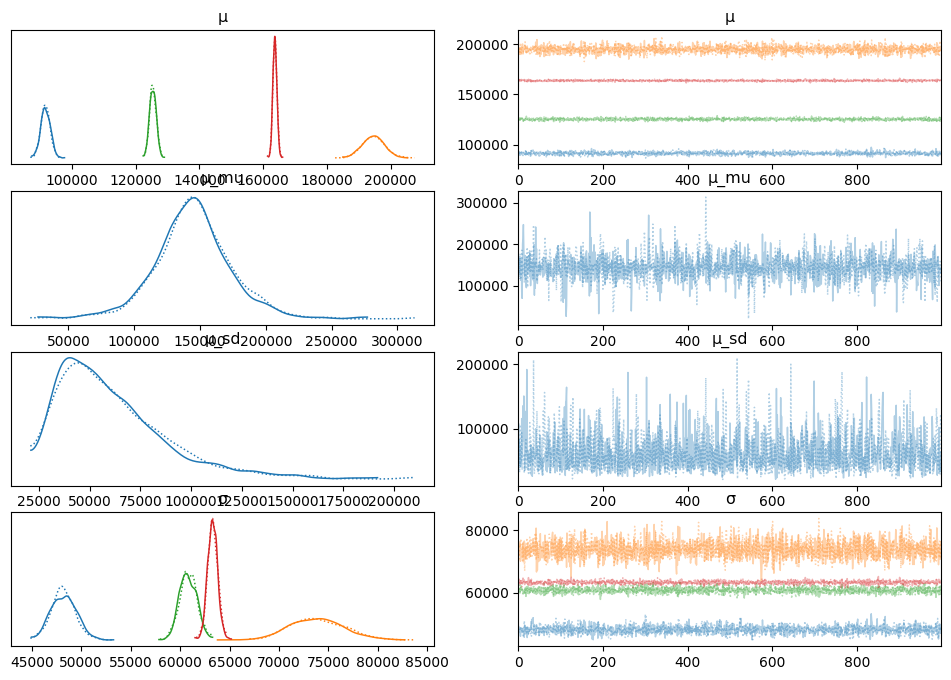

In [27]:
az.plot_trace(idata_dss_h_g)
az.rhat(idata_dss_h_g)